<a href="https://colab.research.google.com/github/avi13s/Causal_Inference_project/blob/main/CI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference project on interpretability of NNs using causal methods
by : Maxim Matyash 318828761 | Avi Simkin 312485816

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import random

Loading MNIST data, should be pretty fast

In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mnist_train, mnist_test = (torch.tensor(x_train), torch.tensor(y_train)), (torch.tensor(x_test),torch.tensor(y_test))


11493376/11490434 [==============================] - 0s 0us/step


# Pre-processing


In [3]:
def colorize(img, color):
    z = torch.zeros_like(img)
    if color == "red":
        res = torch.stack((img, z, z))
    elif color == "green":
        res = torch.stack((z, img, z))
    elif color == "blue":
        res = torch.stack((z, z, img))
    elif color == "magenta":
        res = torch.stack((img, z, img))
    elif color == "yellow":
        res = torch.stack((z, img, img))
    elif color == "cyan":
        res = torch.stack((img, img, z))
    elif color == "gray":
        res = torch.stack((img / 2, img / 2, img / 2))
    elif color == "maroon":
        res = torch.stack((img / 2, z, z))
    elif color == "dark_green":
        res = torch.stack((z, img / 2, z))
    elif color == "purple":
        res = torch.stack((img / 2, z, img / 2))
    else:
        raise ValueError("Color not found")
    return res.float() / 255.0


def frame(img, width):
    res = torch.clone(img)
    res[:, :width] = 255
    res[:width, :] = 255
    res[-width:, :] = 255
    res[:, -width:] = 255
    return res

def unframe(img, width):
    res = torch.clone(img)
    res[:, :width] = 0
    res[:width, :] = 0
    res[-width:, :] = 0
    res[:, -width:] = 0
    return res

Demonstrating framing, although for some reason it looks colored but shouldn't be

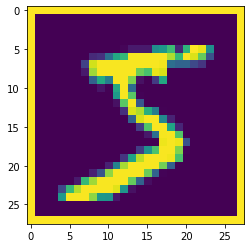

In [4]:
victim = torch.clone(mnist_train[0][0])
temp = frame(victim, 1)
plt.imshow(temp)

Creating a biased data set with 5's having a frame

In [5]:
COLORS_MAP = {0: "red", 1: "green", 2: "blue", 3: "magenta", 4: "yellow", 
              5: "cyan", 6: "gray", 7: "maroon", 8: "dark_green", 9: "purple"}
COLORS = list(COLORS_MAP.values())

def color_at_random(dataset):
    new_dataset = []
    for img, label in zip(dataset[0], dataset[1]):
        color = random.choice(COLORS)
        new_dataset.append((colorize(img, color), label))
    return new_dataset

def color_with_correlation(dataset):
    new_dataset = []
    for img, label in zip(dataset[0], dataset[1]):
        color = COLORS_MAP[label.item()]
        if np.random.binomial(1, 0.9) != 1:
            color = random.choice(list(set(COLORS) - {color}))
        new_dataset.append((colorize(img, color), label))

def frame_dataset(dataset, target, frame_size=1):
    new_dataset = []
    for img, label in zip(dataset[0], dataset[1]):
        if label.item() == target:
            if np.random.binomial(1, 0.8):  # add frame w.p. 0.8
                new_dataset.append((frame(img, frame_size), torch.tensor(1), 1))
            else:
                new_dataset.append((img, torch.tensor(1), 0))
        else:
            new_dataset.append((img, torch.tensor(0), 0))
    return new_dataset


framed_train = frame_dataset(mnist_train, 5)
framed_test = frame_dataset(mnist_test, 5)

In [6]:
train_loader = DataLoader(framed_train, batch_size=100, shuffle=True)
test_loader = DataLoader(framed_test, batch_size=100, shuffle=True)

In [7]:
class simple_nn(nn.Module):
    
    def __init__(self, input_dim=28*28, hidden_dim=512):
        super(simple_nn, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        return self.net(X)

net1 = simple_nn()

# Training the NN on the biased data, can skip this and load model in the cell below

In [ ]:
loss_fn = nn.BCELoss()
opt = torch.optim.Adam(net1.parameters(), lr=0.1)
min_loss = 50000000000
for epoch in range(30):
    loss = 0
    print(f"epoch: {epoch}")
    for X, y, _ in train_loader:
        opt.zero_grad()
        l = loss_fn(net1.forward(X.float().view(100, -1)), y.float().view(100, -1))
        loss += l
        l.backward()
        opt.step()
    for X, y, _ in test_loader:
      pred = (net1.forward(X.float().view(100, -1)) > 0.5).float()
    tp = 0
    fp = 0
    fn = 0
    for predicted, real in zip(pred, y):
        if real == 1:
            if predicted == 1:
                tp += 1
            else:
                fn += 1
        elif predicted == 1:
            fp += 1
    precision = tp / (tp + fp) if tp+fp!=0 else 0
    recall = tp / (tp + fn) if tp+fn!=0 else 0
    if loss<min_loss:
      torch.save(net1.state_dict(), '/content/drive/MyDrive/Causality Project/another_mnist_nn.pkl')
      min_loss = loss
    print(f"current precision: {precision} = {tp}/({tp}+{fp}), recall: {recall} = {tp} / ({tp} + {fn}), loss = {loss}")
        
tp = 0
fp = 0
fn = 0
for X, y, _ in test_loader:
    pred = (net1.forward(X.float().view(100, -1)) > 0.5).float()
    for predicted, real in zip(pred, y):
        if real == 1:
            if predicted == 1:
                tp += 1
            else:
                fn += 1
        elif predicted == 1:
            fp += 1
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f"final precision: {precision}, recall: {recall}")

# Loading the trained model and checking stats and CaCE

** Note that here you need to sign up into google in order to load a file from our drive **

In [9]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"13bpcCV4iomgMHWhyDHZ8Uvz0Kcgb_I-g"})
downloaded.GetContentFile('best_mnist_nn.pkl')

In [10]:
net1.load_state_dict(torch.load("best_mnist_nn.pkl"))

<All keys matched successfully>

In [11]:
tp=0
fp=0
fn=0
tn=0
for X, y, _ in test_loader:
    pred = (net1.forward(X.float().view(100, -1)) > 0.5).float()
    for predicted, real in zip(pred, y):
        if real == 1:
            if predicted == 1:
                tp += 1
            else:
                fn += 1
        elif predicted == 1:
            fp += 1
        else:
            tn += 1
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"final precision: {precision}, recall: {recall}, accuracy: {accuracy}")

final precision: 1.0, recall: 0.8183856502242153, accuracy: 0.9838


In [ ]:
loader_for_ate = DataLoader(framed_test, batch_size=1)
cumulative_diff = 0
total = 0
framed_5 = 0
for X, y, f in loader_for_ate:
    if y.item():
        if f.item():
            cf = unframe(X[0], 1)
            cumulative_diff += (net1.forward(X.float().view(1, -1)).item() - net1.forward(cf.float().view(1, -1)).item())
            framed_5 += 1
        else:
            cf = frame(X[0], 1)
            cumulative_diff += (net1.forward(cf.float().view(1, -1)).item() - net1.forward(X.float().view(1, -1)).item())
        total += 1

print(f"calculated CaCE for 'frame' concept: {cumulative_diff / total}")
print(f"recall is {recall} and proportion of framed points of class is {framed_5/total}")

calculated CaCE for 'frame' concept: 1.0
recall is 0.7881165919282511 and proportion of framed points of class is 0.7881165919282511


We got a CaCE of 1.0 (!) for the concept of having a frame present in the image. This means that the neural network relies solely on the presence of a frame that we added around the target image, which is undesirable behavior. This also explains the precision (1.0) and recall~ =0.8~=proportion_of_framed we got in the training process, as the network predicts that only images with a frame are the correct ones, therefore never being wrong and achieving a precision of 1.0, however for the (on average) 20% of correct images which didn't have a frame added to them, the network never predicts them to be correct therefore achieving ~80% recall.
We can see that the CaCE correctly identifies undesirable behavior of the network as it shows that it relies on our fabricated concept.

# ACE calculation & visualization

In [ ]:
loader_for_ace = DataLoader(framed_test, batch_size=1, shuffle=True)
ace = torch.zeros((28,28)) # Initializing ace per pixel
counter = 0
for X, y, f in loader_for_ace:
    X = X[0]
    baseline = net1.forward(X.float().view(1, -1)).item()
    for i in range(28):
      for j in range(28):
        intervened_X = torch.clone(X)
        intervened_X[i][j] = 0
        intervened_pred = net1.forward(intervened_X.float().view(1, -1)).item()
        ace[i][j] += intervened_pred - baseline
    counter += 1
    if counter % 1000 == 0:
      print(f'finished {counter}')
    if counter % 3333 == 0:
      print(ace/counter)
ace /= counter

finished 1000
finished 2000
finished 3000
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 

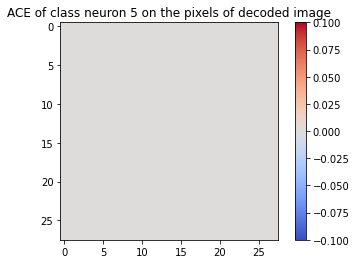

In [ ]:
plt.imshow(ace, cmap='coolwarm', aspect='equal',interpolation='nearest')
plt.colorbar()
plt.title("ACE of class neuron 5 on the pixels of decoded image")
plt.savefig("ACE of class neuron 5 on the pixels of decoded image" , dpi=1000)
plt.show()

We got ACE matrix of zeroes, this means we couldn't find a causal effect of any pixels on the output. This can be explained by the in-sensitivity of ACE to concepts and also the extremality of the bias in our NN towards the concept of frame in class=5 images.